In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
import yfinance as yf

In [14]:
data = pd.DataFrame(yf.download("ORGE.IS", start="2020-01-01", end="2025-08-31",interval="1d", auto_adjust=True))
data.columns = data.columns.droplevel(1)
data.head(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3.11875,3.17500,3.08750,3.10625,3344579
2020-01-03,3.08750,3.17500,3.03125,3.09375,5692059
2020-01-06,2.93125,3.08125,2.93125,3.03125,3541092
2020-01-07,2.98750,3.04375,2.97500,2.97500,1944358
2020-01-08,2.93750,3.03750,2.91250,2.91875,2216019
2020-01-09,3.12500,3.14375,3.02500,3.03125,3471531
2020-01-10,3.16250,3.22500,3.10000,3.14375,5605443
2020-01-13,3.19375,3.21875,3.18125,3.21875,3308347
2020-01-14,3.20000,3.21875,3.17500,3.21875,2202094


## Data Exploration

In [16]:
data_month = data.resample("M").mean()
data_year = data.resample("A-DEC").mean()
data_Q = data.resample("Q-DEC").mean()

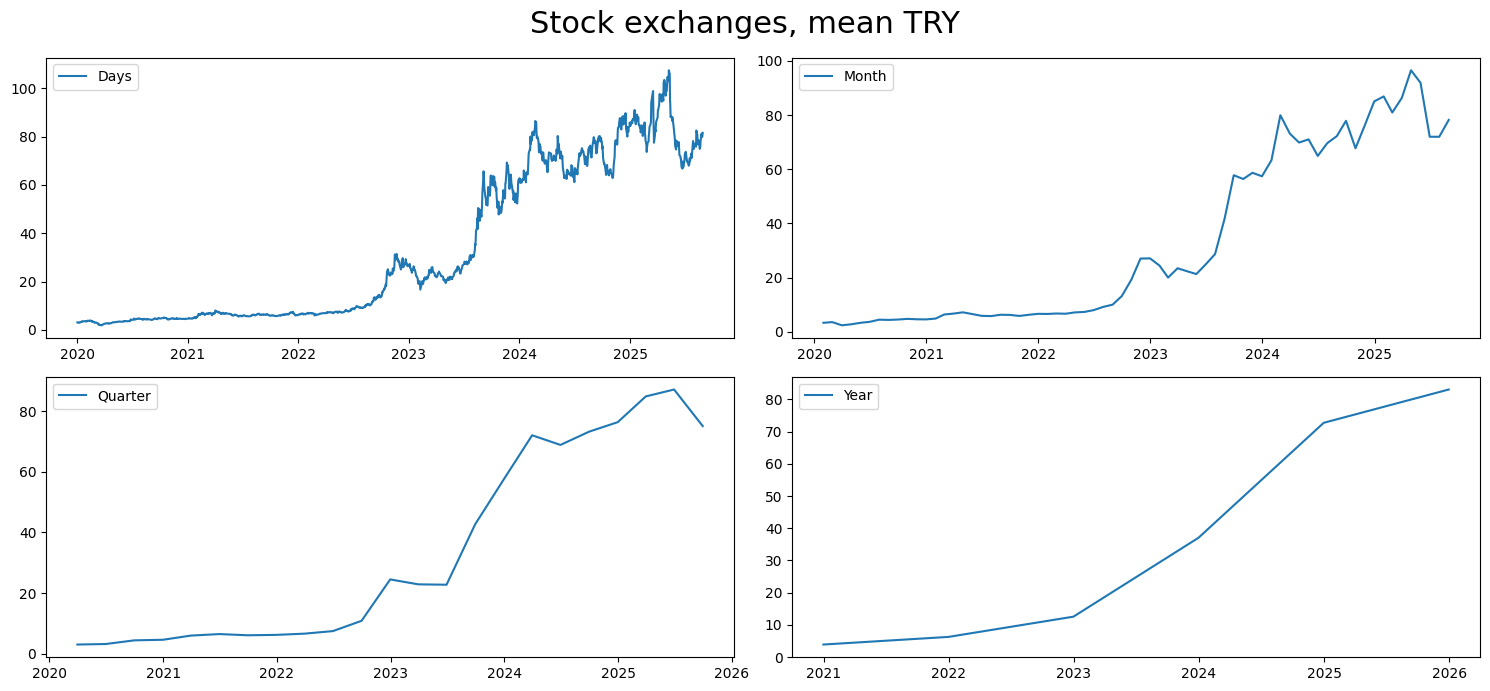

In [24]:
# Plots

fig = plt.figure(figsize=[15, 7])
plt.suptitle("Stock exchanges, mean TRY", fontsize=22)

plt.subplot(221)
plt.plot(data.Close, "-", label = "Days")
plt.legend()

plt.subplot(222)
plt.plot(data_month.Close, "-", label = "Month")
plt.legend()

plt.subplot(223)
plt.plot(data_Q.Close, "-", label = "Quarter")
plt.legend()

plt.subplot(224)
plt.plot(data_year.Close, "-", label = "Year")
plt.legend()

plt.tight_layout()
plt.show()

Stationarity check and STL-decomposition of the series

Dickey-Fuller test: p=0.947056


<Figure size 1500x700 with 0 Axes>

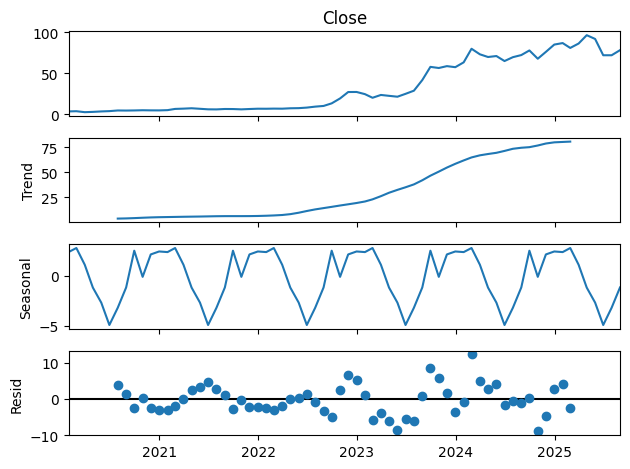

In [29]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(data_month.Close).plot()

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Close)[1])

plt.show()

The series are not stationary.

## Box-Cox Transformations

In [33]:
data_month["Close_box"], lmbda = stats.boxcox(data_month.Close)

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Close_box)[1])

Dickey-Fuller test: p=0.834836


The series are not stationary.

## Seasonal differentiation

In [37]:
data_month["Close_box_diff"] = data_month.Close_box.shift(12)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Close_box_diff[12:])[1])

Dickey-Fuller test: p=0.934305


The series are not stationary.

## Regular differantiation

Dickey-Fuller test: p=0.000002


<Figure size 1500x700 with 0 Axes>

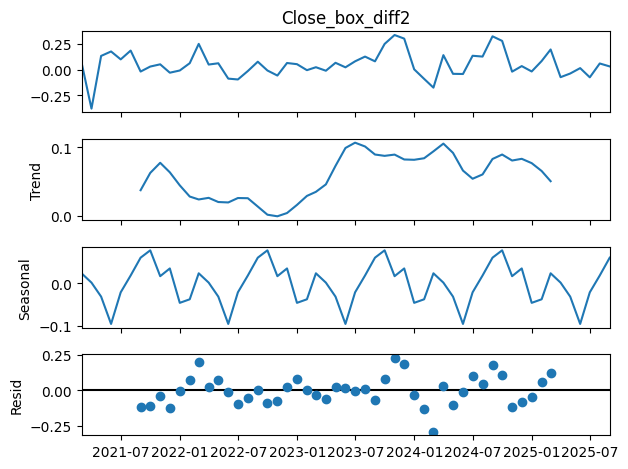

In [42]:
data_month["Close_box_diff2"] = data_month.Close_box_diff - data_month.Close_box_diff.shift(1)

plt.figure(figsize = (15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(data_month.Close_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Close_box_diff2[13:])[1])

plt.show()

## Model Selection

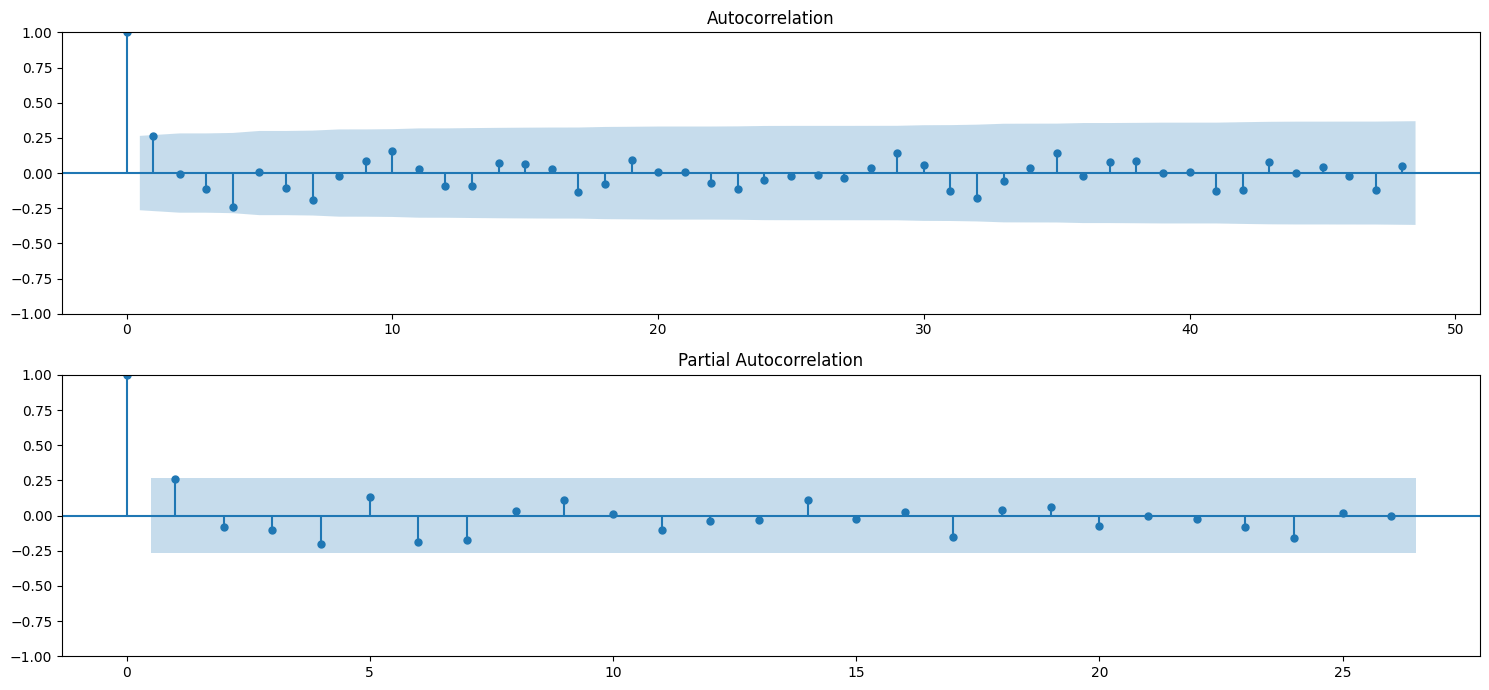

In [55]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
n_obs = len(data_month.Close_box_diff2[13:])
max_lags = n_obs // 2 - 1

fig, axes = plt.subplots(2, 1, figsize=(15, 7))

sm.graphics.tsa.plot_acf(data_month.Close_box_diff2[13:].values.squeeze(), lags=48, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_month.Close_box_diff2[13:].values.squeeze(), lags=max_lags, ax=axes[1])
plt.tight_layout()
plt.show()

In [61]:
Qs = range(0, 2)   # Seasonal MA (Q): 0 or 1
qs = range(0, 3)   # MA (q): 0, 1, 2
Ps = range(0, 3)   # Seasonal AR (P): 0, 1, 2
ps = range(0, 3)   # AR (p): 0, 1, 2
D = 1              # Seasonal difference degree
d = 1              # Normal difference degree

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Parameters length: ",len(parameters_list))

# Model Selection

results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data_month.Close_box, order = (param[0], d, param[1]),
                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print("wrong parameters: ", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Parameters length:  54


In [63]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
7   (0, 1, 0, 1) -53.451113
49  (2, 2, 0, 1) -52.996338
19  (1, 0, 0, 1) -52.404510
37  (2, 0, 0, 1) -52.112750
13  (0, 2, 0, 1) -51.860729
                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                   68
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  29.726
Date:                            Thu, 04 Sep 2025   AIC                            -53.451
Time:                                    23:14:40   BIC                            -47.429
Sample:                                01-31-2020   HQIC                           -51.122
                                     - 08-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

* order = (0,1,1)
* d = 1 -> 1 difference was taken for the trend
* q = 1 -> There is a 1 MA term that captures short-term shocks.

* seasonal_order = (0,1,1,12)
* P = 0 - > No seasonal AR.
* D=1 → Seasonal difference is taken (in 12 steps → annual seasonality).
* Q=1 → Seasonal MA exists (important!).
* s=12 → Seasonal period (possibly annual season in monthly data).

* ma.L1 (q=1): 0.3345, p=0.007 → Significant
* ma.S.L12 (Q=1): -0.8679, p=0.163 → Not statistically very strong (p>0.05), but still explains seasonality.
* sigma2: 0.0154, p=0.034 → Significant

Diagnostic Tests

* Ljung-Box test (Q): p=0.86 → Residuals are white noise (i.e. the model explains the series well).
* Jarque-Bera: p=0.38 → Residuals are close to normal distribution.
* Heteroskedasticity test: p=0.31 → Constant variance assumption can be accepted.

## Analysis of residues

Dickey–Fuller test:: p=0.000000


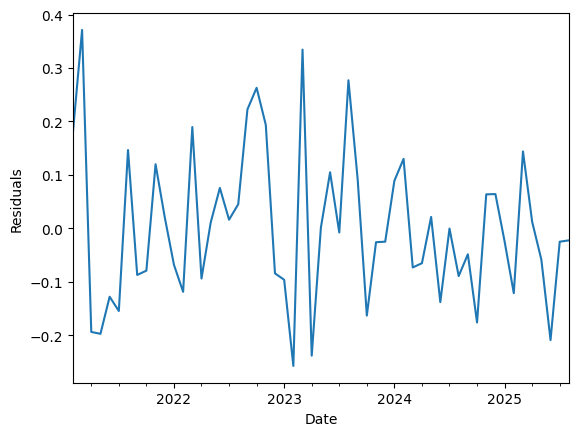

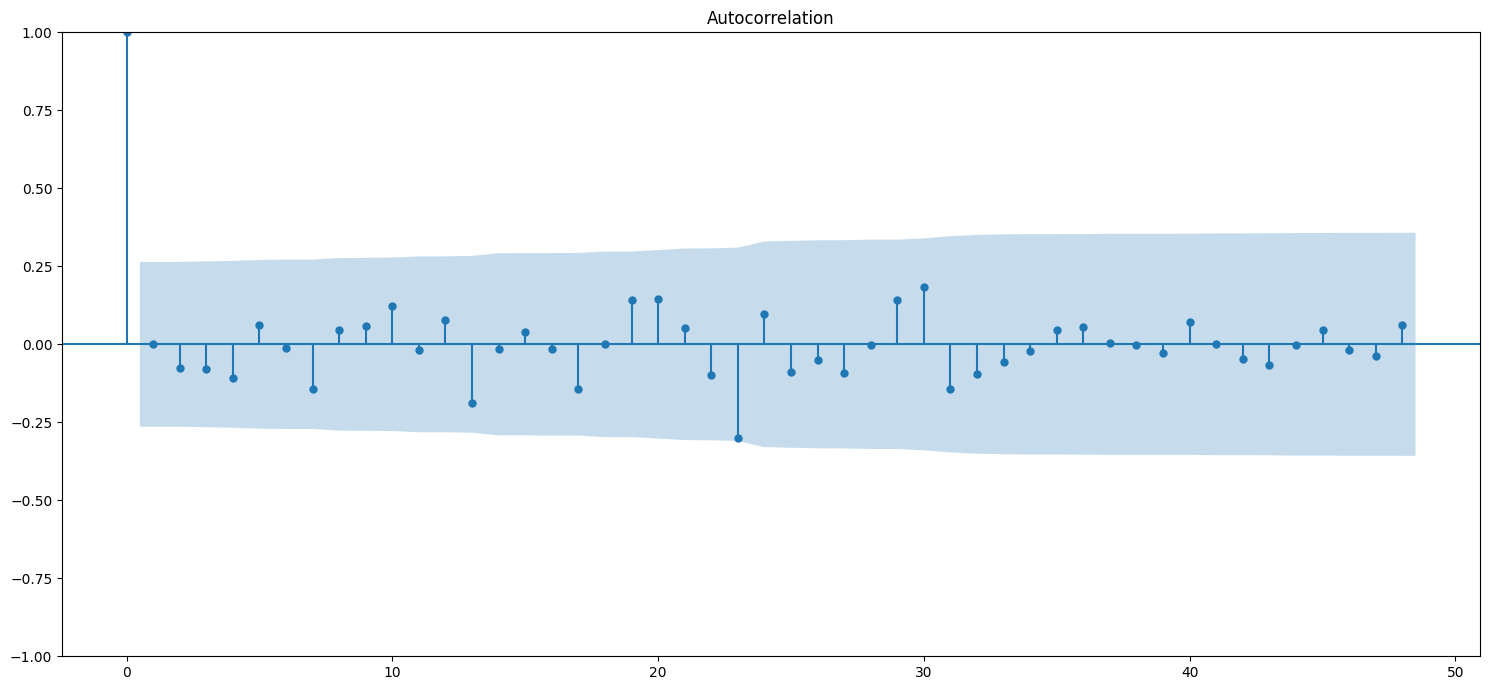

In [75]:
best_model.resid[13:].plot()
plt.ylabel("Residuals")
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=axes)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()


## Prediction

In [78]:
# Inverse Box-Cox

def invboxcox(y, lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return (np.exp(np.log(lmbda*y+1) / lmbda))

In [84]:
data.tail()

Price,Close,High,Low,Open,Volume
Date,,,,,
2025-08-25,81.250000,82.099998,79.099998,79.800003,2464438
2025-08-26,80.650002,81.650002,79.000000,80.699997,1683473
2025-08-27,79.900002,81.099998,79.300003,80.550003,1306898
2025-08-28,80.400002,81.000000,79.750000,79.900002,844718
2025-08-29,81.599998,83.800003,80.550003,80.550003,2278008


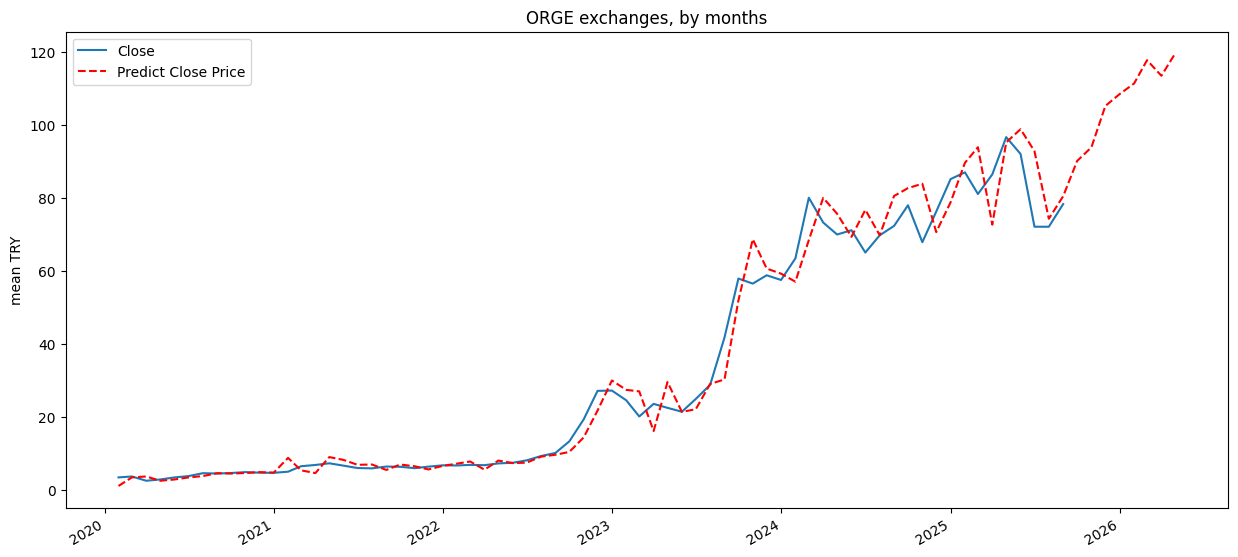

In [86]:
data_month2 = data_month[["Close"]]
date_list = [datetime(2025, 9, 30), datetime(2025, 10, 31), datetime(2025, 11, 30), datetime(2025,12, 31), 
             datetime(2026, 1, 31), datetime(2026, 2, 28), datetime(2026, 3, 31), datetime(2026, 4, 30),
             datetime(2018, 5, 31)]

future = pd.DataFrame(index = date_list, columns = data_month.columns)
data_month2 = pd.concat([data_month2, future])
data_month2["forecast"] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
data_month2.Close.plot()
data_month2.forecast.plot(color="r", ls="--", label="Predict Close Price")
plt.legend()
plt.title("ORGE exchanges, by months")
plt.ylabel("mean TRY")
plt.show()